<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> MAnet for segmentation of remote sensing images </div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> 
📌
Research paper - 
    <a href="https://arxiv.org/abs/2009.02130"> Link </a><br>
📌 Refer this <a href="https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/discussion/425901"> Byte sized primer on choosing the right segmentation model(Competition's Discussion forum) </a><br>
</div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">Contents of the notebook </div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> 
1. Visualizing few band images along with their segmentations.<br>
2. Preprocessing and creating dataloaders.<br>
3. Defining MANet architecture.<br>
4. Training and validation loop along with checkpointing the model.<br>
5. Generate predictions <br>
<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> 
    📌 <b>What's New: 💡</b> <br>
    1. Data Augmentation.<br>
    2. Visual validation of input-output pairs generated by the dataloaders.<br>
    3. Weighted Loss(nn.BCEwithLogitsLoss with pos_weight arg)<br>
    4. Learning rate scheduler.<br>
    5. MAnet model conceptualized as Ideal for the task.<br>
    6. Training on complete train/val split of data with false color generated image by blending multiple channels & their mask.<br></div>
    
 

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Importing modules    </div>

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display
import json
from torchvision import transforms
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
1. Visualizing data    </div>

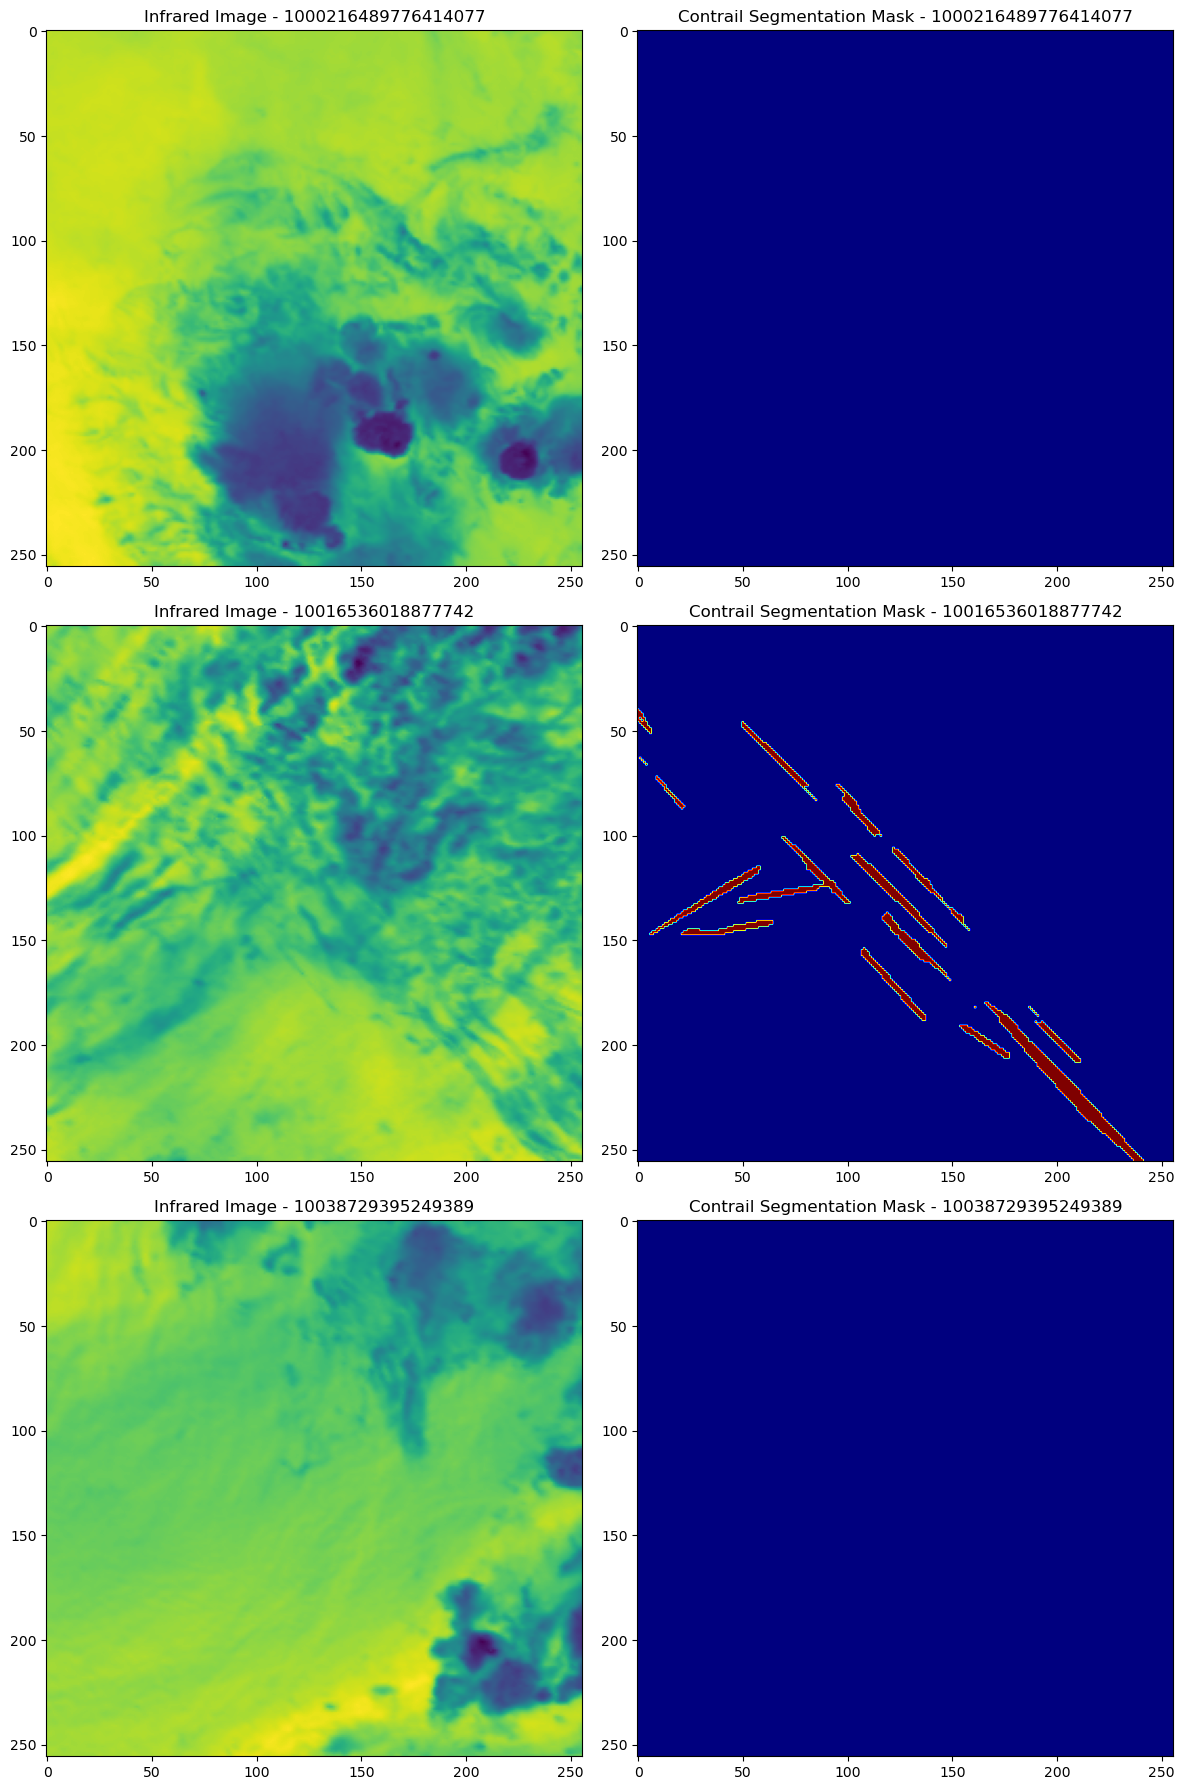

In [2]:
# Load metadata information
with open('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json', 'r') as f:
    metadata = json.load(f)

# Helper function to load data
def load_data(record_id, mode = "train"):
    if mode == "train":
        folder_path = f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/{record_id}/'
    elif mode =="val":
        folder_path = f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation/{record_id}/'
    else:
        folder_path = f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/{record_id}/'

            
        
    bands = [np.load(f'{folder_path}band_{i:02d}.npy') for i in range(8, 17)]
    human_pixel_masks = np.load(f'{folder_path}human_pixel_masks.npy')
    return bands, human_pixel_masks

# Visualize sample images and their segmentation masks
record_ids = ['1000216489776414077', '10016536018877742', '10038729395249389']

fig, axes = plt.subplots(len(record_ids), 2, figsize=(12, 6*len(record_ids)))

for i, record_id in enumerate(record_ids):
    bands, human_pixel_masks = load_data(record_id)

    # Choose a frame to visualize
    frame_index = 5
    image = bands[0][:, :, frame_index]  # Choose band 08 for visualization
    mask = human_pixel_masks[:, :, 0]

    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f'Infrared Image - {record_id}')
    axes[i, 1].imshow(mask, cmap='jet')
    axes[i, 1].set_title(f'Contrail Segmentation Mask - {record_id}')

plt.tight_layout()
plt.show()


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
2. Preprocessing the data and creating dataloaders    </div>

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),  # Example: Random rotation up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Example: Random horizontal flip with 50% probability
])

# Custom Dataset class with false color image generation
class ContrailsDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.record_ids = os.listdir(data_dir)

    def __len__(self):
        return len(self.record_ids)

    def __getitem__(self, idx):
        record_id = self.record_ids[idx]
        record_dir = os.path.join(self.data_dir, record_id)

        bands = []
        for i in range(8, 17):
            band_path = os.path.join(record_dir, f"band_{i:02d}.npy")
            with open(band_path, 'rb') as f:
                band = np.load(f)
                bands.append(band)

        with open(os.path.join(record_dir, 'human_pixel_masks.npy'), 'rb') as f:
            human_pixel_mask = np.load(f)

        # Combine bands into a false color image
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)

        def normalize_range(data, bounds):
            """Maps data to the range [0, 1]."""
            return (data - bounds[0]) / (bounds[1] - bounds[0])

        r = normalize_range(bands[7] - bands[6], _TDIFF_BOUNDS)
        g = normalize_range(bands[6] - bands[3], _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(bands[6], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)

        return {'bands': false_color, 'mask': human_pixel_mask}


train_data_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
valid_data_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation'
batch_size = 1
num_epochs = 10
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = ContrailsDataset(train_data_dir)
valid_dataset = ContrailsDataset(valid_data_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Performing sanity check of the dataloaders by visually inspecting the I/O pairs   </div>

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


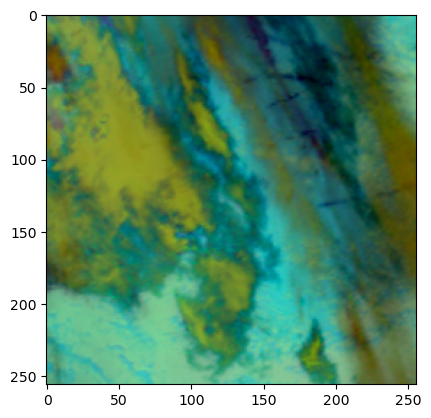

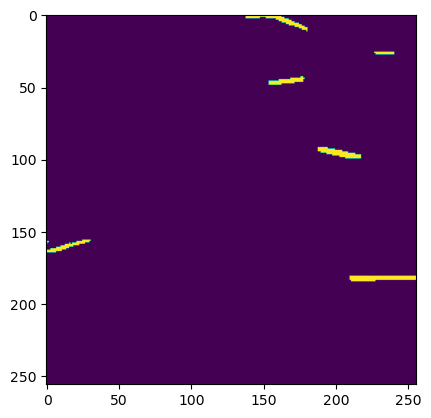

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


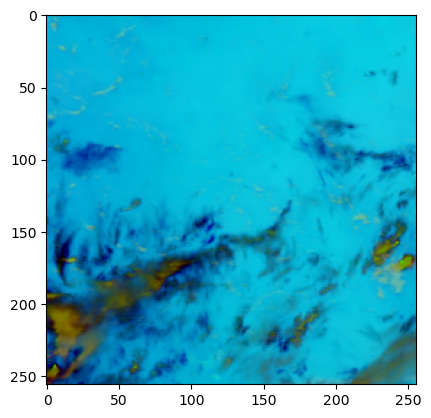

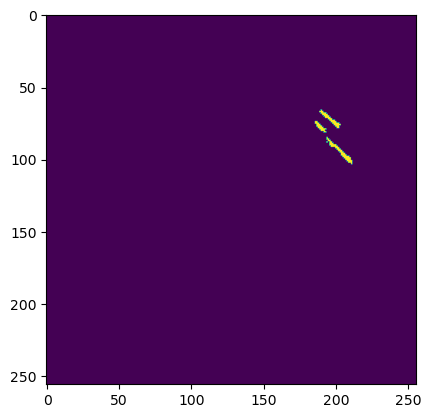

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


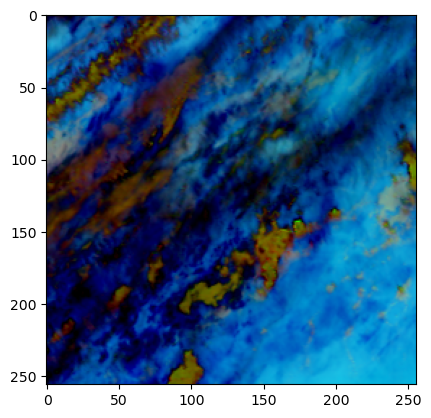

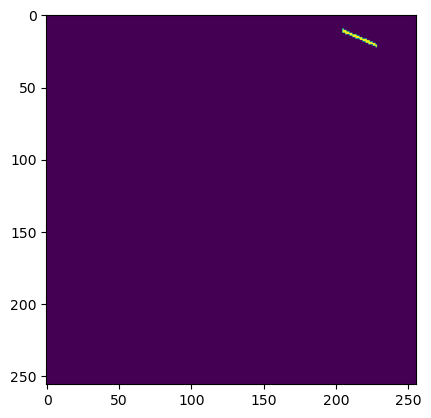

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


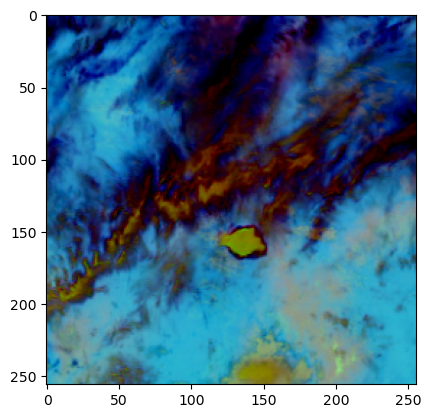

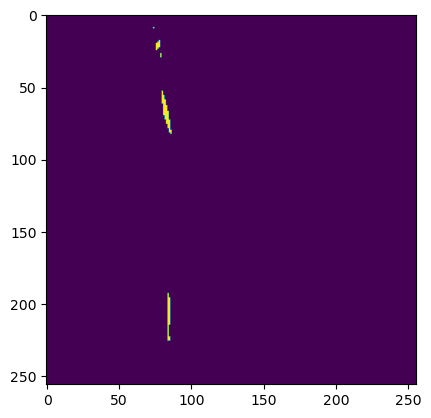

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


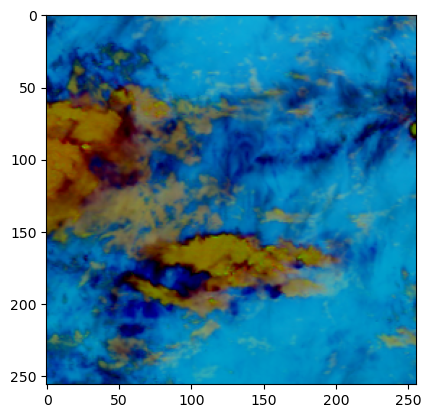

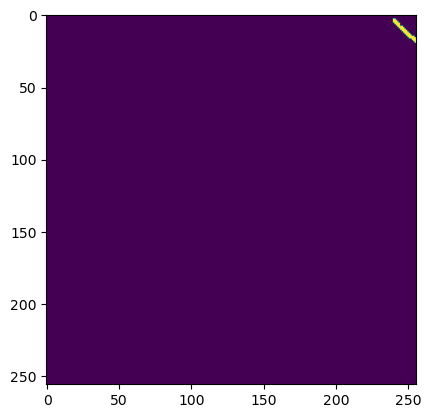

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


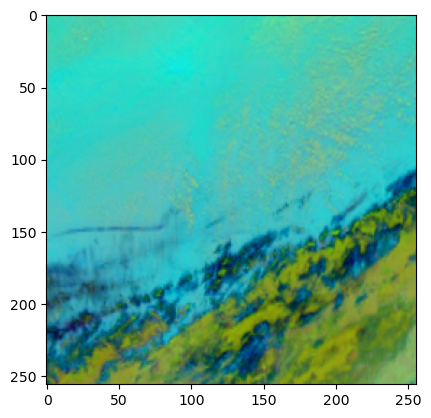

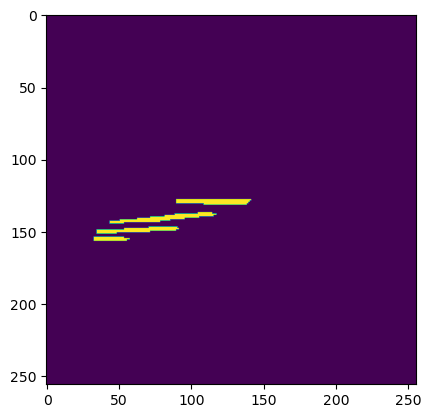

In [4]:
count=0
for batch in train_loader:
    bands, mask =  batch['bands'].squeeze(0), batch['mask'].squeeze(0)
    if len(np.unique(mask)) > 1:
        print(bands[:,:,:,0].shape,mask.shape)

        plt.imshow(bands[:,:,:,0])
        plt.show()
        plt.imshow(mask)
        plt.show()
        count+=1
    if count>5:
        break

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


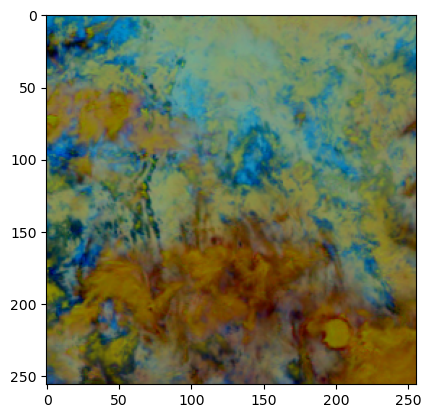

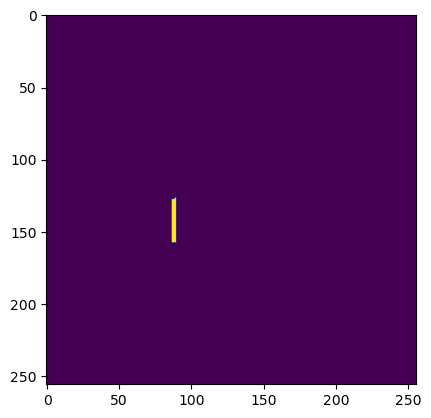

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


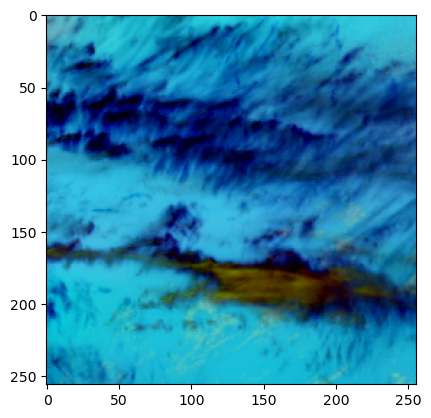

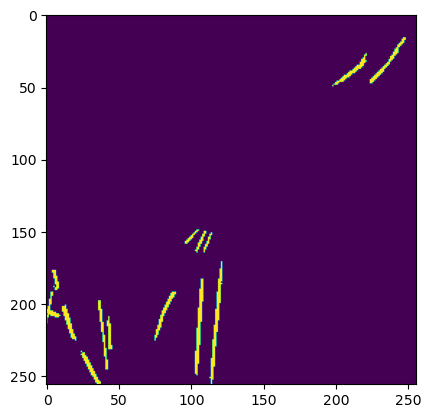

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


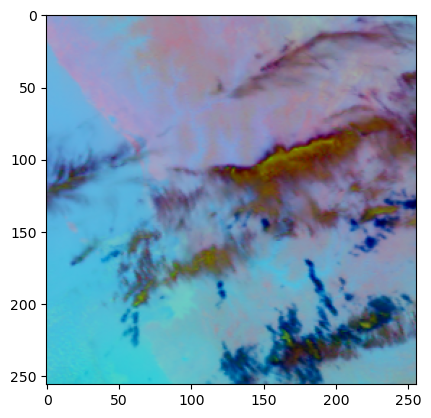

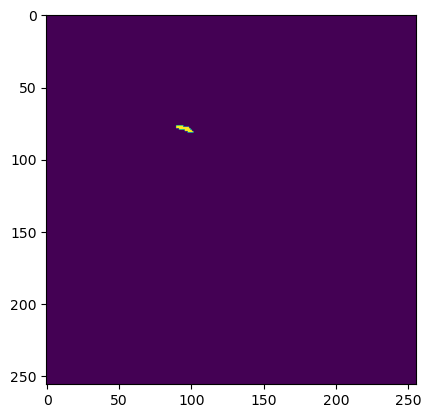

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


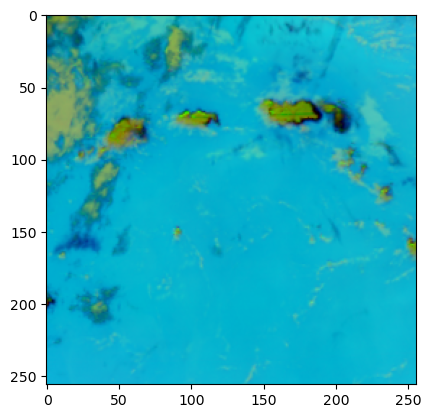

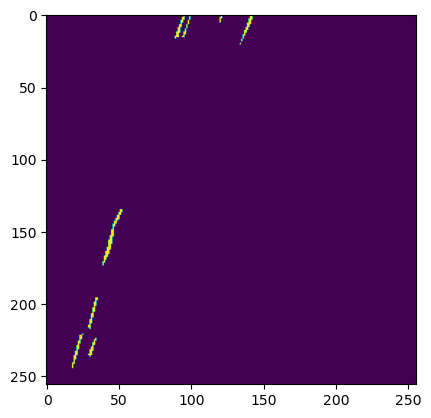

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


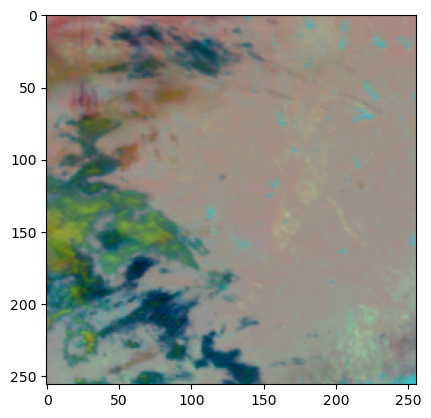

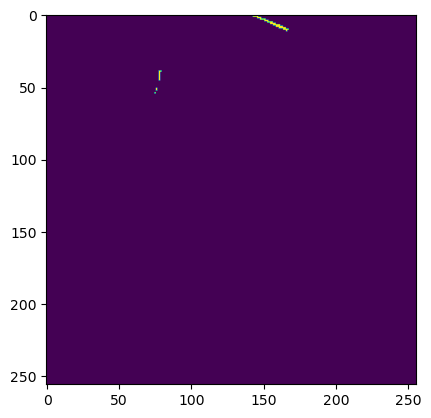

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


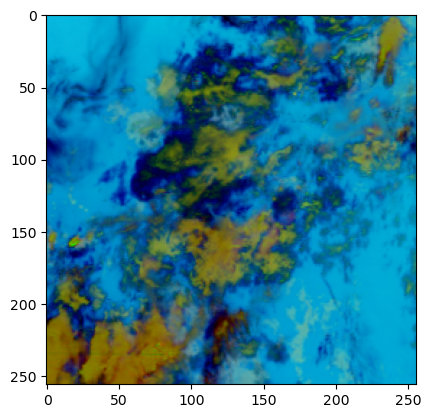

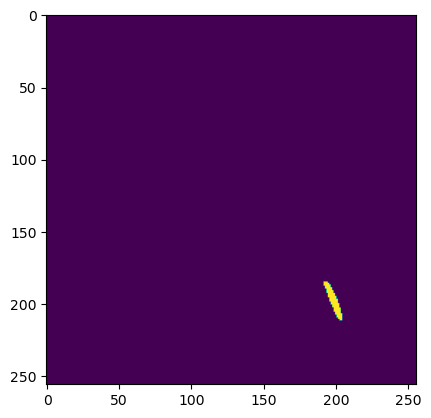

In [5]:
count=0
for batch in valid_loader:
    bands, mask =  batch['bands'].squeeze(0), batch['mask'].squeeze(0)
    if len(np.unique(mask)) > 1:
        print(bands[:,:,:,0].shape,mask.shape)

        plt.imshow(bands[:,:,:,0])
        plt.show()
        plt.imshow(mask)
        plt.show()
        count+=1
    if count>5:
        break

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
3. Defining the MANet architecture with Spatial Attention    </div>

In [6]:
class MAnet(nn.Module):
    def __init__(self):
        super(MAnet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        
        # First attention block
        self.attention1 = self._make_attention_block(64)
        # Second attention block
        self.attention2 = self._make_attention_block(64)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(64, 1, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()
        
    def _make_attention_block(self, in_channels):
        # Attention block consists of three convolutional layers followed by ReLU and Sigmoid activations
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, in_channels // 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, in_channels, kernel_size=1, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Apply the first convolutional layer
        out = self.conv1(x)
        out = self.relu(out)
        
        # Apply the first attention block
        attention1 = self.attention1(out)
        # Apply the second attention block
        attention2 = self.attention2(out)
        
        # Combine the output using element-wise multiplication with attention masks
        out = out * attention1 + out * attention2
        
        # Apply the second convolutional layer followed by sigmoid activation
        out = self.conv2(out)
        out = self.sigmoid(out)
        
        return out

# Create an instance of the MAnet model
model = MAnet()

# Test the model with a random input
input = torch.randn(2, 3, 256, 256)  # Batch size of 2
output = model(input)
print(output.shape)  # Should print: torch.Size([2, 1, 256, 256])


torch.Size([2, 1, 256, 256])


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
4. Training the model on MANet data along with validating and saving the model   </div>

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

""" Weighted Loss computation takes time.. Uncomment to process
#Calculate the class weights based on the training data
contrail_pixels = sum([np.sum(mask) for _, mask in tqdm(train_dataset)])
total_pixels = sum([np.prod(mask.shape) for _, mask in tqdm(train_dataset)])
weight_non_contrail = total_pixels / (total_pixels - contrail_pixels)
weight_contrail = total_pixels / contrail_pixels
"""
# # Create the weighted loss function
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight_contrail))
criterion = nn.BCEWithLogitsLoss()

# Initialize the model and optimizer
model = MAnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 0.1 every 5 epochs

# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0.0
    for step, batch in enumerate(train_loader):
        images, masks = batch['bands'][:,:,:,:,0].to(device), batch['mask'].to(device)
        images, masks = images.permute(0,3,1,2), masks.permute(0,3,1,2)
        #images = images[:,:,:,]
        #print(images,masks)

        # Forward pass
        outputs = model(images)  # Add channel dimension
        #print(outputs)

        # Calculate loss
        loss = criterion(outputs, masks.float())
        total_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        scheduler.step()
        if step%100==0:
            print("Step-{}, Loss-{}".format(step, loss.item()))

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Validation loop
model.eval()
with torch.no_grad():
    total_val_loss = 0.0
    for images, masks in (valid_loader):
        images, masks = batch['bands'][:,:,:,:,0].to(device), batch['mask'].to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        val_loss = criterion(outputs, masks.unsqueeze(1).float())
        total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')

# Save the model checkpoint
torch.save(model.state_dict(), 'MANet_contrail_segmentation.pth')


  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Step-0, Loss-0.9434913396835327
Step-100, Loss-0.951458215713501
Step-200, Loss-0.9402022361755371
Step-300, Loss-0.9410650730133057
Step-400, Loss-0.9484010934829712
Step-500, Loss-0.9551199674606323
Step-600, Loss-0.940900981426239
Step-700, Loss-0.9453403353691101
Step-800, Loss-0.927972674369812
Step-900, Loss-0.9412871599197388
Step-1000, Loss-0.9401381611824036
Step-1100, Loss-0.9480010867118835
Step-1200, Loss-0.9407604336738586
Step-1300, Loss-0.9485727548599243
Step-1400, Loss-0.9412698745727539
Step-1500, Loss-0.9512684345245361
Step-1600, Loss-0.950160801410675
Step-1700, Loss-0.9430056214332581
Step-1800, Loss-0.937410831451416
Step-1900, Loss-0.9405516386032104
Step-2000, Loss-0.9447396397590637
Step-2100, Loss-0.9498425126075745


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
5. Generate predictions   </div>

In [ ]:
def predict_on_test_set(model, test_record_ids):
    model.eval()
    test_predictions = {}
    with torch.no_grad():
        for record_id in test_record_ids:
            folder_path = f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/{record_id}/'
            bands = [np.load(f'{folder_path}band_{i:02d}.npy') for i in range(8, 17)]
            test_images = torch.tensor(bands[0][:, :, 5], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            test_outputs = model(test_images)
            test_predictions[record_id] = test_outputs.squeeze(0).squeeze(0).cpu().numpy()

    return test_predictions


test_record_ids = ['1000834164244036115', '1002653297254493116']  # Replace with rd ids
model = MANetWithSpatialAttention().to(device)
model.load_state_dict(torch.load('MANet_contrail_segmentation.pth'))

# Generate test set predictions
test_predictions = predict_on_test_set(model, test_record_ids)

def rle_encode(mask):
    pixels = mask.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

submission = pd.DataFrame(columns=['record_id', 'prediction'])
for record_id, prediction in test_predictions.items():
    encoded_prediction = rle_encode((prediction > 0.5).astype(np.int))
    submission = submission.append({'record_id': record_id, 'prediction': encoded_prediction}, ignore_index=True)

submission.to_csv('submission.csv', index=False)
